In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 데이터셋 불러오기
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 267kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.10MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.1MB/s]


In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train='False',
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
# 트레인 데이터셋에 있는 데이터들의 최대값
train_dataset.data.max()
# 결과값: tensor(255, dtype=torch.uint8)

# 테스트 데이터셋의 사이즈를 가져오기
test_dataset.data.shape
# 결과값: torch.Size([60000, 28, 28]) (이미지 수, 너비, 높이)

torch.Size([60000, 28, 28])

In [ ]:
# 클래스 수 세보기

K = len(set(train_dataset.targets.numpy()))
# train_dataset.targets: 각 이미지의 정답(label)을 담고 있는 텐서
# .numpy(): 텐서를 넘파이 배열로 변환
# set(...): 중복을 제거하여 유일한 클래스만 남김
# len(...): 전체 유일 클래스 수를 세어 K에 저장

print("number of classes:", K)
# MNIST는 0부터 9까지 10개의 숫자 클래스


number of classes: 10


In [ ]:
# 모델 만들기
class CNN(nn.Module):
    def __init__(self, K):  # K는 분류할 클래스 개수
        super(CNN, self).__init__()

        # ▶ 합성곱(Convolutional) 계층: 이미지에서 공간적 특징을 추출
        # 합성곱 출력 크기 = [(입력크기 - 커널크기) / 스트라이드] + 1
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            # 입력: (1, 28, 28) → 출력: (32, 13, 13)
            # 계산: [(28 - 3) / 2] + 1 = 13.5 → 버림 = 13
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            # 입력: (32, 13, 13) → 출력: (64, 6, 6)
            # 계산: [(13 - 3) / 2] + 1 = 6

            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            # 입력: (64, 6, 6) → 출력: (128, 2, 2)
            # 계산: [(6 - 3) / 2] + 1 = 2

            nn.ReLU()
        )

        # ▶ 완전연결(Dense) 계층: 추출된 특징을 기반으로 분류 결정
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),  # 과적합 방지를 위해 20% 뉴런을 무작위로 꺼줌 (학습 시만)

            nn.Linear(128 * 2 * 2, 512),
            # 마지막 Conv 출력인 (128채널, 2, 2) → 총 128*2*2 = 512차원 벡터로 변환하여 입력
            # 입력 크기: (배치크기, 512) → 출력 크기: (배치크기, 512)

            nn.ReLU(),  # 비선형 활성화 함수(음수는 0, 양수는 그대로)

            nn.Dropout(0.2),  # 또 한 번 과적합 방지를 위한 드롭아웃

            nn.Linear(512, K)
            # 최종 출력층: 클래스 개수만큼 출력
            # 예: MNIST라면 K=10 → 10개 클래스 각각의 점수를 출력 (softmax는 나중에 loss에서 처리)
        )
    def forward(self, x):
     out = self.conv_layers(x)
     out = out.view(out.size(0), -1)
     out = self.dense_layers(out)
     return out

# CNN 모델 객체 생성
model = CNN(K)


In [ ]:
# : 다중 클래스 분류에서 정수 레이블로 출력하고자 할 때 쓰는 대표적 손실 험수
criterion = nn.CrossEntropyLoss()
# 텐서플로우의 sparse_categorical_crossentrop와 동일한 역할


optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# batch size = 128로 나누고
batch_size =128

train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.73MB/s]


In [ ]:
# 에폭 15로 학습 후 출력하자
from datetime import datetime


def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs) :
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    train_loss = []
    t0 = datetime.now()
    for inputs, targets in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)


    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
  return train_losses, test_losses


In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.3165, Test Loss: 0.0909, Duration: 0:00:34.120538
Epoch 2/15, Train Loss: 0.0974, Test Loss: 0.0579, Duration: 0:00:32.874500
Epoch 3/15, Train Loss: 0.0661, Test Loss: 0.0459, Duration: 0:00:33.405017
Epoch 4/15, Train Loss: 0.0519, Test Loss: 0.0427, Duration: 0:00:32.146528
Epoch 5/15, Train Loss: 0.0429, Test Loss: 0.0425, Duration: 0:00:32.984133
Epoch 6/15, Train Loss: 0.0370, Test Loss: 0.0376, Duration: 0:00:32.645246
Epoch 7/15, Train Loss: 0.0315, Test Loss: 0.0334, Duration: 0:00:32.374368
Epoch 8/15, Train Loss: 0.0270, Test Loss: 0.0367, Duration: 0:00:32.916235
Epoch 9/15, Train Loss: 0.0241, Test Loss: 0.0349, Duration: 0:00:34.081598
Epoch 10/15, Train Loss: 0.0216, Test Loss: 0.0340, Duration: 0:00:34.000093
Epoch 11/15, Train Loss: 0.0205, Test Loss: 0.0332, Duration: 0:00:32.251557
Epoch 12/15, Train Loss: 0.0182, Test Loss: 0.0355, Duration: 0:00:32.261958
Epoch 13/15, Train Loss: 0.0149, Test Loss: 0.0334, Duration: 0:00:32.534302
Epoch 14

In [ ]:
# 마지막은 항상 정확도...
def compute_accuracy(model, data_loader):
  model.eval()
  # training 모드 : 정확도 향상을 위한 연산 --> evaluation mode : 정확도 연산이 비활성화
  n_correct = 0
  n_total = 0
  with torch.no_grad():
    for inputs, targets in data_loader:
      outputs = model(inputs)
      _, predictions = torch.max(outputs, 1) # 가장 확률이 높은 클래스를 선택해서 출력
      n_correct += (predictions == targets).sum().item()
      n_total += targets.size(0)

  return n_correct / n_total

train_acc = compute_accuracy(model, train_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.9984, Test Accuracy: 0.9907


[[ 974    1    0    0    2    0    1    2    0    0]
 [   0 1134    0    0    0    0    0    0    1    0]
 [   0    0 1021    1    1    0    1    5    3    0]
 [   0    0    1 1003    0    2    0    1    3    0]
 [   0    0    1    0  974    0    3    0    0    4]
 [   1    0    0    7    0  882    1    1    0    0]
 [   4    3    0    1    1    1  946    0    2    0]
 [   0    2    8    1    0    0    0 1014    0    3]
 [   1    0    0    0    1    1    0    0  970    1]
 [   0    0    0    0   13    1    0    3    3  989]]


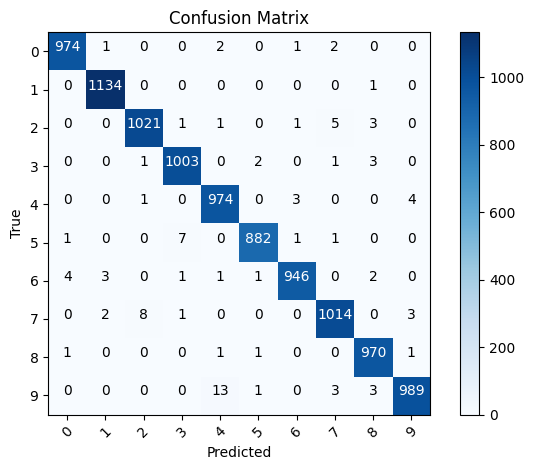

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

# [1] 혼동 행렬 시각화 함수 정의
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    cm : 계산된 confusion matrix (2D array)
    classes : 클래스 이름 또는 인덱스 리스트 (예: [0,1,2,...,9])
    normalize : 정규화 여부 (기본 False)
    """
    print(cm)  # 숫자 확인용

    # 행렬 이미지 출력
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # x축, y축 클래스 이름 설정
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 셀 안에 값 표시
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel("Predicted")  # 예측된 클래스
    plt.ylabel("True")       # 실제 클래스
    plt.tight_layout()
    plt.show()


# [2] 테스트셋 예측 결과 수집
p_test = np.array([])  # 예측 결과 저장용
y_test = np.array([])  # 실제 정답 저장용

model.eval()  # 평가 모드로 전환 (드롭아웃, 배치정규화 등 비활성화)

# 배치 단위로 반복하며 예측 수행
with torch.no_grad():  # 역전파 비활성화 (메모리 효율땜시)
    for inputs, labels in test_loader:
        outputs = model(inputs)  # 모델 예측값
        _, predictions = torch.max(outputs, 1)  # 가장 높은 확률의 클래스 선택

        # GPU로 하면 빠르다고 해서 쓸 수 도 있응께 .cpu() 사용 후 numpy 변환
        p_test = np.concatenate((p_test, predictions.cpu().numpy()))
        y_test = np.concatenate((y_test, labels.cpu().numpy()))

# [3] 혼동 행렬 계산
cm = confusion_matrix(y_test, p_test)

# [4] 매트릭스 보기
plot_confusion_matrix(cm, list(range(10)))  # 클래스 0~9

In [ ]:
# 0 ~ 9번 클래스에 의류 이름 리스트로 정의
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")

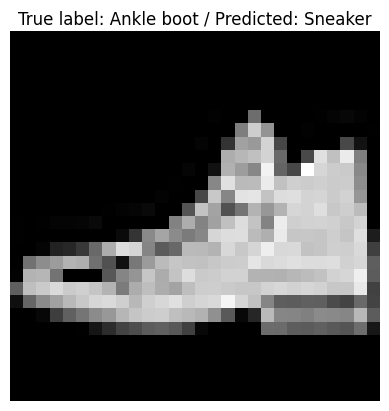

In [ ]:
# 테스트 데이터 이미지 배열을 NumPy 배열로 변환
# (N, 1, 28, 28) 형태의 4차원 배열 (N: 샘플 수, 1: 채널, 28x28 픽셀)
x_test = np.array(x_test)

# 예측값(p_test)과 실제값(y_test)을 부호 없는 8비트 정수형으로 변환
# (메모리 최적화 및 타입 오류 방지 목적)
p_test = p_test.astype(np.uint8)
y_test = y_test.astype(np.uint8)

# 오분류된 샘플들의 인덱스를 추출
# p_test != y_test 조건에 해당하는 위치를 가져옴
misclassified_idx = np.where(p_test != y_test)[0]

# 오분류된 샘플 중 하나를 무작위로 선택
i = np.random.choice(misclassified_idx)

# 선택된 오분류 샘플의 이미지 시각화
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')  # 1채널 이미지로 복원 후 회색조로 출력

# 이미지 위에 실제 라벨과 예측 라벨 표시
plt.title("True label: %s / Predicted: %s" % (
    labels[int(y_test[i])], labels[int(p_test[i])]
))

# 축 눈금 제거 (이미지 깔끔하게 보기 위해)
plt.axis('off')
plt.show()